### Project Title : - Using Lung ultrasound images for building a reliable Point-of-care Covid-19 testing system

#### Binary Classifier : For classifying lung ultrasound images into one of the two categories : Covid and Non Covid

In [ ]:
#Mounting the google drive as the data is available there

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#Changing the current working directory
cd drive/MyDrive/

/content/drive/MyDrive


#### Loading and pre-processing for training data

In [ ]:
#Importing the libraries
import pathlib
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
import numpy as np

p = Path().cwd()
q = p/'binary_two'/'train' # use p to create a path to the data 


#There are two classes in the training data
target_dict = {"covid" : 1 , "non_covid" : 0 }
images = [] # create an empty list
labels = [] # create an empty list  

#This piece of code loads the images, resize them to 197X198 pixels and append them to a list

#Label for every image is appended to the list as well

for fldr in q.iterdir(): 
    current_label = fldr.name # get the name of the current label 
    print(current_label)  
    for img in fldr.iterdir():
        img = load_img(img,grayscale = True)
        img_array = img_to_array(img) # convert the image to an NumPy array 
        size = (197,198)
        img_array_resized = smart_resize(img_array,size)
        images.append(img_array_resized)# add reshaped image to list of images 
        labels.append(current_label)# add label for this image to the list of labels 
        



covid


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


non_covid


In [ ]:
X_train = np.array(images) # convert the list of images to a NumPy array 
y_train = np.array(labels) # convert the list of labels to a NumPy array

In [ ]:
# use the target_dict to convert the string labels to an array of integers

y_train = np.asarray(list(map(lambda x: target_dict[x] if x in target_dict.keys() else x , y_train))) 

In [ ]:
#normalizing the images by making sure that the pixel values lie between 0 and 1

X_train = X_train/255.0

In [ ]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array

nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny*nrgb))

#### Loading and pre-processing of test data

In [ ]:
#The same image loading and pre-processing steps have to be performed for the test dataset

p = Path().cwd()
q = p/'binary_two'/'test' # use p to create a path to the data 

target_dict = {"covid" : 1 , "non_covid" : 0 }
images = [] # create an empty list
labels = [] # create an empty list  

 
for fldr in q.iterdir(): 
    current_label = fldr.name # get the name of the current label 
    print(current_label)  
    for img in fldr.iterdir():
        img = load_img(img,grayscale = True)
        img_array = img_to_array(img) # convert the image to an NumPy array 
        size = (197,198)
        img_array_resized = smart_resize(img_array,size)
        images.append(img_array_resized)# add reshaped image to list of images 
        labels.append(current_label)# add label for this image to the list of labels 
        



non_covid


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


covid


In [ ]:
X_test = np.array(images) # convert the list of images to a NumPy array 
y_test = np.array(labels) # convert the list of labels to a NumPy array

In [ ]:
# use the target_dict to convert the string labels to an array of integers

y_test = np.asarray(list(map(lambda x: target_dict[x] if x in target_dict.keys() else x , y_test))) 


In [ ]:
#Normalizing the images in the test set
X_test = X_test/255.0

In [ ]:
#eventually,model.predict() should also be a 2d input

nsamples, nx, ny, nrgb = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny*nrgb))

#### Near Miss undersampling

In [ ]:
#ImbalancedLearn library provides the methods of undersampling and oversampling we'll be using

!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Implementing Near Miss undersampling technique from imbalanced learn library, which undersamples the majority class and reduces the no. of samples to as that of the minority class
import imblearn
from imblearn.under_sampling import NearMiss

nm = NearMiss()


#Resampling the training dataset
X,y = nm.fit_resample(X_train, y_train)

#### Support Vector Machine model

In [ ]:
# define support vector classifier
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X,y)


SVC(kernel='linear', probability=True, random_state=42)

In [ ]:
# generate predictions
y_pred = svm.predict(X_test)



#### Testing the model's performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8653915553951642


In [ ]:
#Printing the classification report to get a picture of performance on both classes

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1588
           1       1.00      0.68      0.81      1183

    accuracy                           0.87      2771
   macro avg       0.90      0.84      0.85      2771
weighted avg       0.89      0.87      0.86      2771



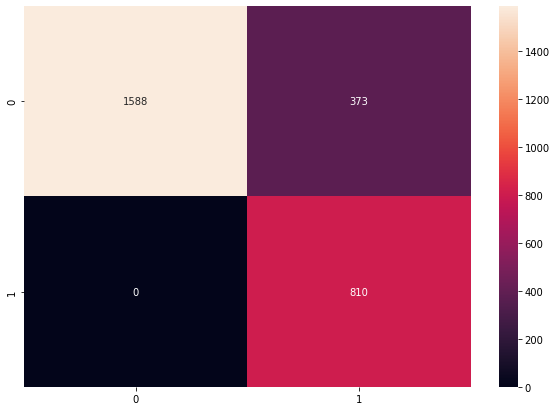

In [ ]:
#Visualizing the confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

confusion_matrix(y_pred,y_test)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot = True, fmt ='g')

#### SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
#Oversampling is another technique for dealing with class imbalance. SMOTE from imbalanced learn library creates instances in the minority class, so that both of the classes have equal instances
from imblearn.over_sampling import SMOTE

#Creating an instance of SMOTE
sm = SMOTE(random_state=42)

#Resampling the training data uisng SMOTE
X,y  = sm.fit_resample(X_train, y_train)

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Now, we'll be using Random Forest Classifier for classifying the images after oversampling

forest = RandomForestClassifier(n_estimators = 100, random_state = 234, n_jobs = -1 )

#Model training
forest.fit(X,y)

RandomForestClassifier(n_jobs=-1, random_state=234)

In [ ]:
#Getting predictions on the test data

y_pred= forest.predict(X_test)

#### Testing model's performance on test data

In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

# calculate accuracy
accuracy = accuracy_score(y_test,y_pred)
print('Model accuracy is: ', accuracy)


Model accuracy is:  0.8902923132443161


In [ ]:
#The classification report gives a view of model's performance for both the classes - Covid and Non Covid

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1657
           1       1.00      0.73      0.84      1114

    accuracy                           0.89      2771
   macro avg       0.92      0.86      0.88      2771
weighted avg       0.91      0.89      0.89      2771



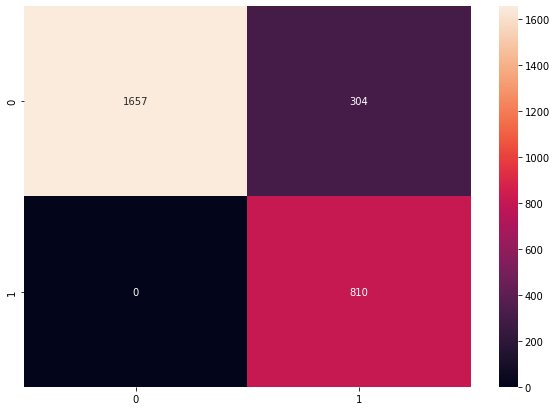

In [ ]:
#Visualizing the confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

confusion_matrix(y_pred,y_test)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot = True, fmt ='g')

#### Logistic Regression Model

In [ ]:
#Logistic regression model is being fitted on the training data, for this one no technique has been used for dealing with class imbalance.

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver = 'lbfgs')

lg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
y_pred = lg.predict(X_test)


#### Testing model's performance on test data

In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

# calculate accuracy
accuracy = accuracy_score(y_test,y_pred)
print('Model accuracy is: ', accuracy)


Model accuracy is:  0.8437387224828582


In [ ]:
#Printing the classification report

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1528
           1       1.00      0.65      0.79      1243

    accuracy                           0.84      2771
   macro avg       0.89      0.83      0.83      2771
weighted avg       0.88      0.84      0.84      2771

